# Online Shopper Purchase Intent

Predict purchase intent from user browsing behavior using session-level features.
The notebook focuses on exploratory analysis, model comparison, and recall-oriented evaluation
under class imbalance.


# **1.Import basic librarie**

---



In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay,
    average_precision_score, PrecisionRecallDisplay
)


RANDOM_STATE = 42

import os
os.makedirs("images", exist_ok=True)

np.random.seed(RANDOM_STATE)


# **2. Load Data**

In [6]:
# load dataset
DATA_PATH = "online_shoppers_intention.csv"
df = pd.read_csv(DATA_PATH)

df.head()



,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# **3. Basic Overview**

In [7]:
df.info()
df.describe(include="all").transpose()

# missing values & duplicates check
missing = df.isna().sum().sort_values(ascending=False)
print(missing[missing > 0])

print("Duplicate rows:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

# **4. Target Distribution**

/tmp/ipython-input-1027409969.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


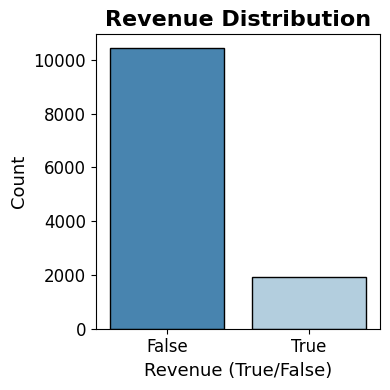

In [8]:
target_col = "Revenue"

df[target_col].value_counts()
df[target_col].value_counts(normalize=True)

plt.figure(figsize=(4, 4))

sns.countplot(
    x=df[target_col],
    palette="Blues_r",
    edgecolor="black"
)

plt.title("Revenue Distribution", fontsize=16, weight="bold")
plt.xlabel("Revenue (True/False)", fontsize=13)
plt.ylabel("Count", fontsize=13)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig("images/target_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# **5. Split Features & Columns**

In [9]:
X = df.drop(columns=[target_col])
y = df[target_col]

numeric_features = [
    "Administrative", "Administrative_Duration",
    "Informational", "Informational_Duration",
    "ProductRelated", "ProductRelated_Duration",
    "BounceRates", "ExitRates", "PageValues", "SpecialDay"
]

categorical_features = [
    "Month", "OperatingSystems", "Browser", "Region",
    "TrafficType", "VisitorType", "Weekend"
]


# **6. Preprocessing Pipeline**

In [10]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# **7. Train/Test Split**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)


# **8. Model Setup**

In [12]:
# Model roles:
# - Logistic Regression: baseline model
# - Decision Tree: interpretable comparison model
# - Random Forest: final selected model (based on PR-AUC)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=8, random_state=RANDOM_STATE
    ),
}


# **9. Training & Evaluation Function**

In [13]:
def train_and_evaluate(name, model):
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print("=" * 40)
    print(name)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Confusion Matrix (save)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"{name} - Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f"images/cm_{name.replace(' ', '_').lower()}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # metrics dict (for results table)
    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": np.nan,
        "pr_auc": np.nan
    }

    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]

        metrics["roc_auc"] = roc_auc_score(y_test, y_proba)
        metrics["pr_auc"] = average_precision_score(y_test, y_proba)

        print("ROC-AUC:", metrics["roc_auc"])
        print("PR-AUC:", metrics["pr_auc"])

        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"{name} - ROC Curve")
        plt.tight_layout()
        plt.savefig(f"images/roc_{name.replace(' ', '_').lower()}.png", dpi=300, bbox_inches="tight")
        plt.show()

        PrecisionRecallDisplay.from_predictions(y_test, y_proba)
        plt.title(f"{name} - Precision-Recall Curve")
        plt.tight_layout()
        plt.savefig(f"images/pr_{name.replace(' ', '_').lower()}.png", dpi=300, bbox_inches="tight")
        plt.show()

    return pipe, metrics

# **10. Train All Models**

Logistic Regression
Accuracy: 0.8807785888077859
              precision    recall  f1-score   support

       False       0.89      0.98      0.93      2084
        True       0.74      0.36      0.48       382

    accuracy                           0.88      2466
   macro avg       0.81      0.67      0.71      2466
weighted avg       0.87      0.88      0.86      2466



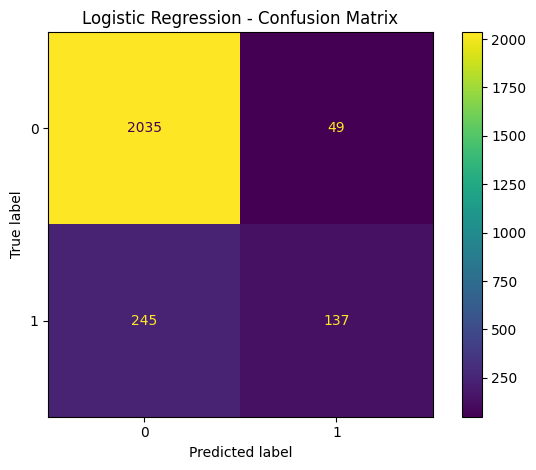

ROC-AUC: 0.8827868275869
PR-AUC: 0.6188954798256021


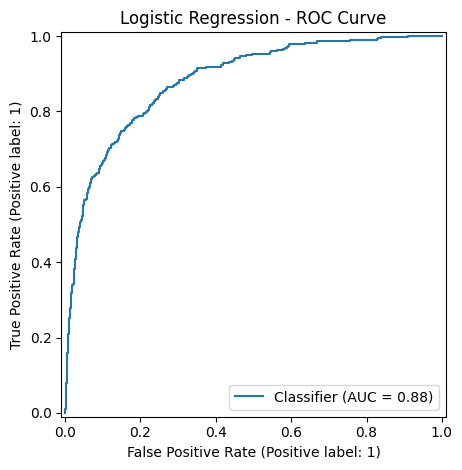

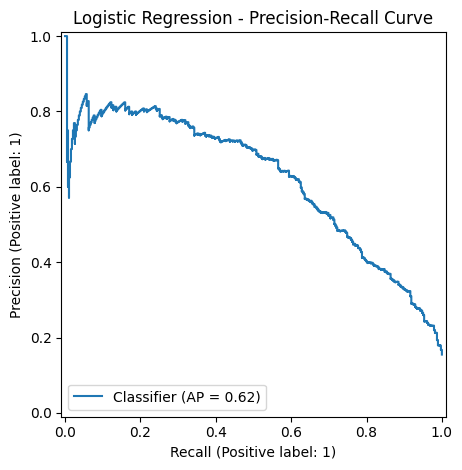

Decision Tree
Accuracy: 0.8965936739659367
              precision    recall  f1-score   support

       False       0.92      0.96      0.94      2084
        True       0.71      0.56      0.63       382

    accuracy                           0.90      2466
   macro avg       0.82      0.76      0.78      2466
weighted avg       0.89      0.90      0.89      2466



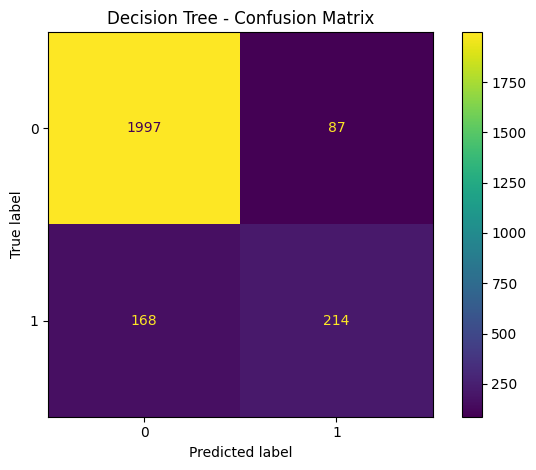

ROC-AUC: 0.907289143913738
PR-AUC: 0.673894293629296


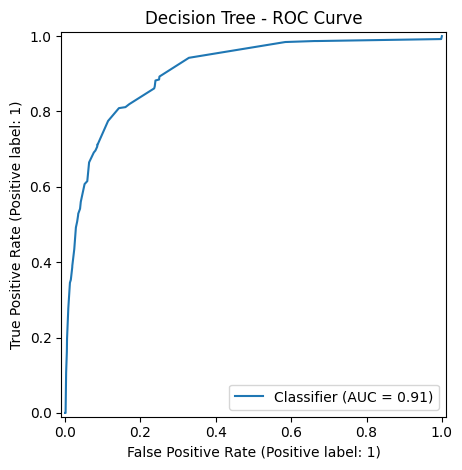

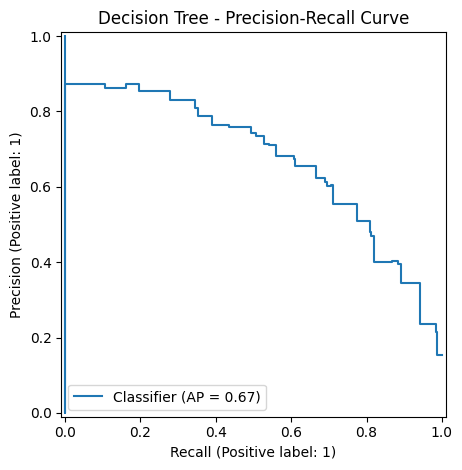

Random Forest
Accuracy: 0.8880778588807786
              precision    recall  f1-score   support

       False       0.89      0.99      0.94      2084
        True       0.87      0.33      0.48       382

    accuracy                           0.89      2466
   macro avg       0.88      0.66      0.71      2466
weighted avg       0.89      0.89      0.87      2466



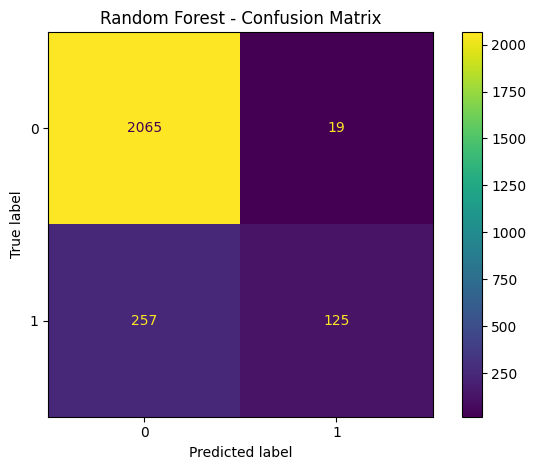

ROC-AUC: 0.909325350966225
PR-AUC: 0.7268265255584684


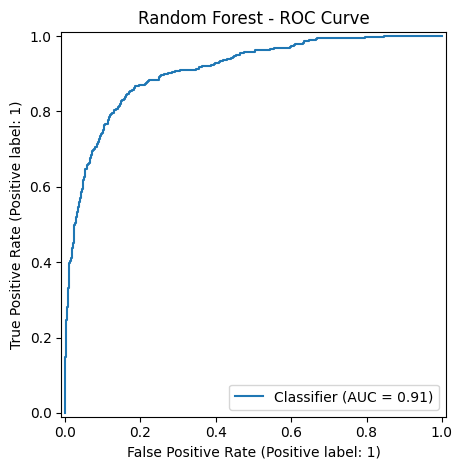

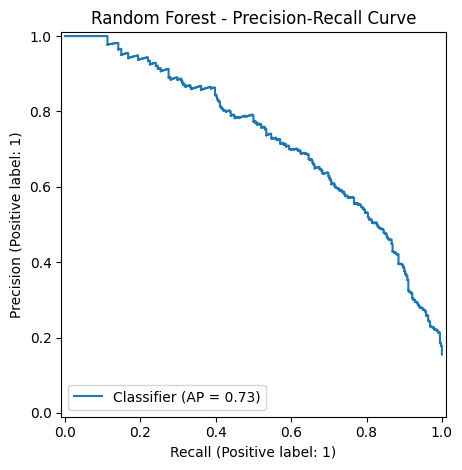

,model,accuracy,roc_auc,pr_auc
2,Random Forest,0.888078,0.909325,0.726827
1,Decision Tree,0.896594,0.907289,0.673894
0,Logistic Regression,0.880779,0.882787,0.618895


In [16]:
trained_models = {}
metrics_list = []

for name, model in models.items():
    clf, m = train_and_evaluate(name, model)
    trained_models[name] = clf
    metrics_list.append(m)

results = pd.DataFrame(metrics_list).sort_values(
    by=["pr_auc", "roc_auc", "accuracy"],
    ascending=False
)

results

### Model Comparison

Models were compared primarily using **PR-AUC**, followed by ROC-AUC and accuracy.


## Final Model Selection

Based on the evaluation results, **Random Forest** was selected as the final model.

Although Decision Tree achieved slightly higher accuracy, **Random Forest showed the best performance on PR-AUC**, which is the most appropriate metric for this imbalanced classification problem where identifying potential purchasers (Revenue=True) is critical.

Therefore, Random Forest was chosen as the final model for this project.


# **11. Feature Importance (Random Forest)**

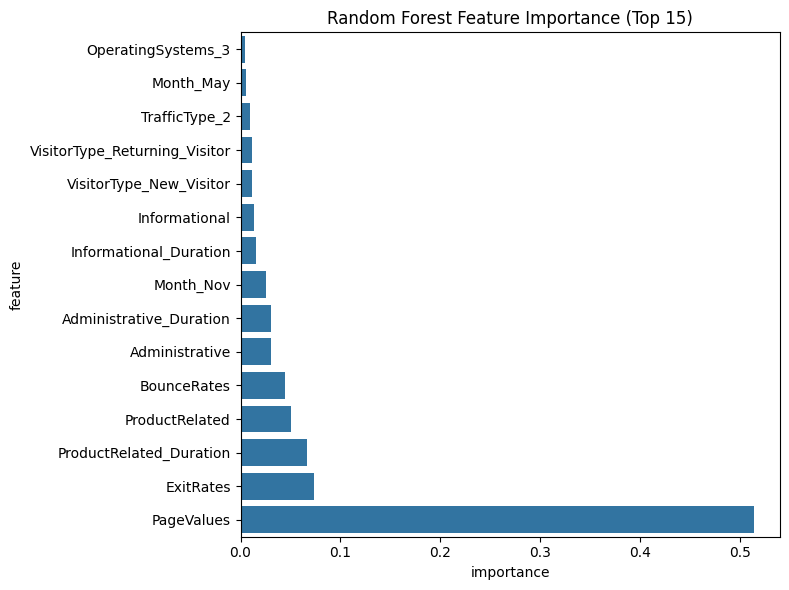

In [15]:
rf = trained_models.get("Random Forest")

if rf is not None:
    rf_model = rf.named_steps["model"]
    ohe = rf.named_steps["preprocess"].named_transformers_["cat"]

    numeric_names = numeric_features
    categorical_names = list(ohe.get_feature_names_out(categorical_features))
    feature_names = numeric_names + categorical_names

    importance = rf_model.feature_importances_

    fi = pd.DataFrame({
        "feature": feature_names,
        "importance": importance
    }).sort_values("importance", ascending=False)

    fi.head(15)

top15 = fi.head(15).iloc[::-1]

plt.figure(figsize=(8,6))
sns.barplot(data=top15, x="importance", y="feature")
plt.title("Random Forest Feature Importance (Top 15)")
plt.tight_layout()
plt.savefig("images/feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

